In [1]:
import pandas as pd
import glob
import os

def mean_speed_aggregation(series):
    """Custom aggregation for mean speed based on sign conditions."""
    positive_values = series[series > 0]
    negative_values = series[series < 0]

    if len(positive_values) > 0 and len(negative_values) == 0:
        return positive_values.mean()  # If all > 0, average them
    elif len(positive_values) == 0 and len(negative_values) > 0:
        return negative_values.mean()  # If all < 0, average them
    elif len(positive_values) > 0 and len(negative_values) > 0:
        return positive_values.mean()  # Keep only the > 0 values
    else:
        return 0  # Edge case: if everything is 0 or NaN

# Collect all e1detectors_*.csv files (adjust pattern/path as needed)
csv_files = glob.glob("e1/e1detectors_*.csv")

all_data = []

for file_path in csv_files:
    # Example filename: e1detectors_attack_989.csv
    filename = os.path.basename(file_path)  # => e1detectors_attack_989.csv
    parts = filename.split("_")            # => ['e1detectors', 'attack', '989.csv']

    scenario = parts[1]                    # => 'attack' or 'base' etc.
    seed_str = parts[2].replace(".csv", "")  # => '989'

    # Read the CSV
    df = pd.read_csv(file_path, sep=";")

    # Ensure columns are as expected. If they differ, rename them accordingly:
    # df.rename(columns={'begin':'interval_begin', 'flow':'interval_flow', ...}, inplace=True)

    # Add the scenario and seed columns
    df["scenario"] = scenario
    df["seed"] = seed_str  # if you also want the seed in final output, keep it.

    all_data.append(df)

# Combine everything
combined_df = pd.concat(all_data, ignore_index=True)

# Group by scenario, interval_begin, interval_id and compute aggregations
grouped = (
    combined_df
    .groupby(["scenario", "interval_begin", "interval_id"])
    .agg({
        "interval_flow": "mean",  # standard mean for flow
        "interval_harmonicMeanSpeed": mean_speed_aggregation  # custom aggregator
    })
    .reset_index()
)

# Write out the final aggregated CSV
grouped.to_csv("e1/aggregated.csv", index=False)

print("Aggregation complete. Results saved to aggregated.csv.")


Aggregation complete. Results saved to aggregated.csv.


In [2]:
import pandas as pd
import re

# Custom aggregator, same as before
def mean_speed_aggregation(series):
    """Custom aggregation for mean speed based on sign conditions."""
    positive_values = series[series > 0]
    negative_values = series[series < 0]

    if len(positive_values) > 0 and len(negative_values) == 0:
        return positive_values.mean()
    elif len(positive_values) == 0 and len(negative_values) > 0:
        return negative_values.mean()
    elif len(positive_values) > 0 and len(negative_values) > 0:
        return positive_values.mean()
    else:
        return 0

# Load your *already* aggregated CSV (which has scenario, interval_begin, interval_id, etc.)
df = pd.read_csv("e1/aggregated.csv")

# Example "interval_id" values: E0_0_0m, E0_1_0m, E0_0_100m, etc.
# We want to extract "link" (the part before the second underscore) and "pos" (the number before 'm').
# For instance:
#   E0_0_0m   -> link=E0, pos=0
#   E0_1_100m -> link=E0, pos=100
# The second underscore is typically the lane, which we *ignore* in final grouping.

def parse_link_and_pos(interval_id):
    # One approach: split by underscore
    # e.g., "E0_1_100m" -> ["E0", "1", "100m"]
    parts = interval_id.split("_")
    link = parts[0]  # "E0"
    # The "pos" is in the last element, e.g. "100m".
    # We'll parse out the digits before the 'm'
    pos_str = re.sub(r"[^\d]+", "", parts[-1])  # remove non-digits, e.g. "100m" -> "100"
    pos = int(pos_str) if pos_str else 0
    return link, pos

df[["link", "pos"]] = df["interval_id"].apply(lambda x: pd.Series(parse_link_and_pos(x)))

# Now group by scenario, interval_begin, link, pos
# We'll sum the flow and apply your custom aggregator for the speed column
grouped = (
    df
    .groupby(["scenario", "interval_begin", "link", "pos"], as_index=False)
    .agg({
        "interval_flow": "sum",                     # sum the flow
        "interval_harmonicMeanSpeed": mean_speed_aggregation  # custom speed aggregator
    })
)

# If you want a new combined interval_id like "E0_100m" for each row:
grouped["interval_id_combined"] = grouped.apply(
    lambda row: f"{row['link']}_{row['pos']}m", axis=1
)

# Save the new combined/aggregated DataFrame
grouped.to_csv("e1/aggregatedv2.csv", index=False)

print("Combination and aggregation complete. Saved to aggregatedv2.csv.")


Combination and aggregation complete. Saved to aggregatedv2.csv.


In [3]:
import pandas as pd

def compute_spr(row, speed_limit_baseline=112.654):
    """
    Speed Performance Ratio (SPR) logic:
      - If base_speed < 0 and attack_speed > 0 -> use speed_limit_baseline
      - If both < 0 -> -1
      - If base_speed > 0 and attack_speed < 0 -> -2
      - Else normal ratio: attack_speed/base_speed
    """
    base_speed = row["interval_harmonicMeanSpeed_base"]
    attack_speed = row["interval_harmonicMeanSpeed_attack"]

    # base_speed < 0 => no vehicles in base scenario
    # attack_speed < 0 => no vehicles in attack scenario
    if base_speed < 0 and attack_speed > 0:
        return round(attack_speed / speed_limit_baseline, 2)
    elif base_speed < 0 and attack_speed < 0:
        return -1  # No vehicles in both scenarios
    elif base_speed > 0 and attack_speed < 0:
        return -2  # Total breakdown in attack scenario
    else:
        # Normal ratio
        if base_speed == 0:
            # Edge case: base_speed is 0 but not negative => might be actual 0?
            return -999  # or handle gracefully
        return round(attack_speed / base_speed, 2)

def compute_fr(row):
    """
    Flow Ratio (FR) logic:
      - If base_flow == 0 and attack_flow > 0 -> -1
      - If base_flow > 0 and attack_flow == 0 -> 0
      - If both 0 -> 1
      - Else normal ratio: attack_flow/base_flow
    """
    base_flow = row["interval_flow_base"]
    attack_flow = row["interval_flow_attack"]

    if base_flow == 0 and attack_flow > 0:
        return -1  # Flow appeared where base was 0
    elif base_flow > 0 and attack_flow == 0:
        return 0   # Total failure in attack scenario
    elif base_flow == 0 and attack_flow == 0:
        return 1   # No vehicles in both scenarios
    else:
        return round(attack_flow / base_flow, 2)

def calculate_ratios(data):
    """
    Given a single DataFrame with columns:
      ['scenario', 'time_bin', 'detectorID', 'meanSpeed', 'exitFlow']
    returns a DataFrame with columns:
      ['time_bin', 'detectorID', 'SPR', 'FR',
       'meanSpeed_attack', 'meanSpeed_base',
       'exitFlow_attack', 'exitFlow_base']
    applying custom logic for SPR/FR.
    """

    # Split attack/base
    attack_data = data[data["scenario"] == "attack"].copy()
    base_data = data[data["scenario"] == "base"].copy()

    # Merge on time_bin + detectorID
    merged_data = pd.merge(
        attack_data, base_data,
        on=["interval_begin", "interval_id_combined", "link", "pos"],
        suffixes=("_attack", "_base")
    )

    # Compute SPR & FR
    merged_data["SPR"] = merged_data.apply(compute_spr, axis=1)
    merged_data["FR"] = merged_data.apply(compute_fr, axis=1)

    # Choose columns to keep and round
    output_cols = [
        "interval_begin",
        "interval_id_combined",
        "link",
        "pos",
        "SPR",
        "FR",
        "interval_harmonicMeanSpeed_attack",
        "interval_harmonicMeanSpeed_base",
        "interval_flow_attack",
        "interval_flow_base"
    ]
    # If you also have "density_attack" and "density_base", add them here

    output_data = merged_data[output_cols].round(2)

    return output_data

if __name__ == "__main__":
    # 1. Read your aggregated data
    #    Make sure the columns match the names below or rename them.
    #    For instance, if you have "interval_begin" instead of "time_bin",
    #    do: df.rename(columns={"interval_begin": "time_bin"}, inplace=True) etc.
    df = pd.read_csv("e1/aggregatedv2.csv")

    # Example renaming (adjust if your columns differ):
    # df.rename(columns={
    #    "interval_begin": "time_bin",
    #    "interval_id": "detectorID",
    #    "interval_flow": "exitFlow",
    #    "interval_harmonicMeanSpeed": "meanSpeed"
    # }, inplace=True)

    # 2. Calculate ratios
    ratios_df = calculate_ratios(df)

    # 3. Save results
    ratios_df.to_csv("e1/aggregatedv3.csv", index=False)
    print("Saved SPR and FR ratios to aggregatedv3.csv")


Saved SPR and FR ratios to aggregatedv3.csv


SPR Mean: 0.955546875 FR Mean: 0.9999739583333334


/tmp/ipykernel_1387874/2860330465.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1])


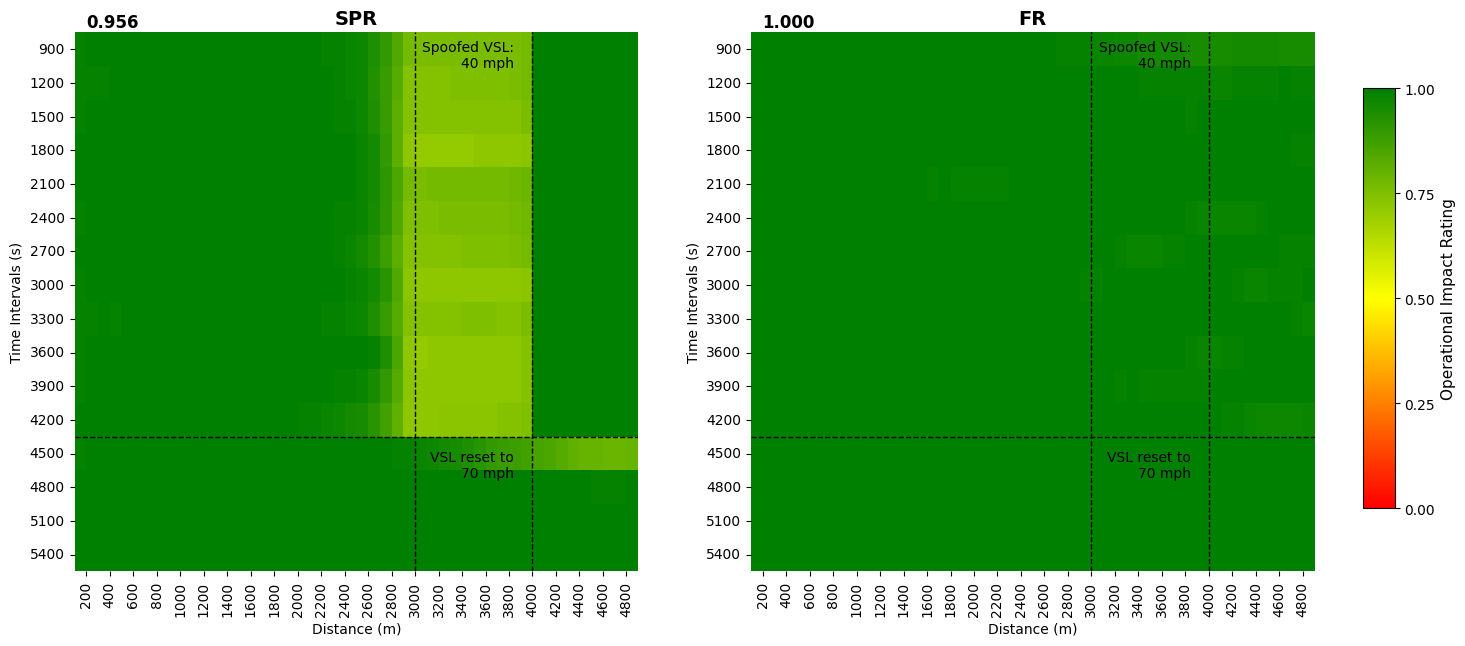

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize, LinearSegmentedColormap

# Load the CSV file with the manually added distance column
file_path = "e1/aggregatedv3.csv"
df = pd.read_csv(file_path)

# Convert `time_bin` and `distance` to integers for proper sorting and filtering
df["interval_begin"] = df["interval_begin"].astype(int)
df["pos"] = df["pos"].astype(int)

# Sort data by `time_bin` (ascending) and `distance` (ascending)
df = df.sort_values(by=["interval_begin", "pos"])

# Define the range for data to include in t9e heatmap
distance_start = 200     # Start distance (inclusive)
distance_end   = 4900    # End distance (inclusive)
time_start     = 900     # Start time (inclusive)
time_end       = 5400    # End time (inclusive)

# Adjust time values so the smallest becomes 0
min_time = df["interval_begin"].min()
df["adjusted_time"] = df["interval_begin"] - min_time

# Filter data based on the defined distance and time ranges
filtered_df = df[(df["pos"] >= distance_start) & (df["pos"] <= distance_end)]
filtered_df = filtered_df[(filtered_df["interval_begin"] >= time_start) & (filtered_df["interval_begin"] <= time_end)]

# Create pivot tables using `distance` instead of `detectorID`
spr_matrix = filtered_df.pivot(index="adjusted_time", columns="pos", values="SPR")
fr_matrix  = filtered_df.pivot(index="adjusted_time", columns="pos", values="FR")

# Calculate the mean for SPR and FR within the specified range
spr_mean = spr_matrix.mean().mean()
fr_mean  = fr_matrix.mean().mean()

print("SPR Mean:", spr_mean, "FR Mean:", fr_mean)

def plot_heatmaps(spr_matrix, fr_matrix):
    cmap = LinearSegmentedColormap.from_list("fixed", ["red", "yellow", "green"], N=256)
    norm = Normalize(vmin=0.0, vmax=1.0)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.2})
    cbar_ax = fig.add_axes([0.93, 0.2, 0.02, 0.6])

    # --- SPR Heatmap (left) ---
    sns.heatmap(spr_matrix, cmap=cmap, norm=norm, cbar=False, ax=axes[0])
    axes[0].set_title("SPR", fontsize=14, fontweight="bold")
    axes[0].set_xlabel("Distance (m)")
    axes[0].set_ylabel("Time Intervals (s)")

    # Example: label x‐ticks more sparsely
    col_positions = np.arange(1, len(spr_matrix.columns), 2)
    axes[0].set_xticks(col_positions)
    # axes[0].set_xticks(np.arange(0, len(spr_matrix.columns), 2))
    axes[0].set_xticklabels(spr_matrix.columns[::2], rotation=90)

    # --- FR Heatmap (right) ---
    sns.heatmap(fr_matrix, cmap=cmap, norm=norm, cbar=False, ax=axes[1])
    axes[1].set_title("FR", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("Distance (m)")
    axes[1].set_ylabel("Time Intervals (s)")
    # axes[1].set_ylabel("")  # no label needed if you prefer
    col_positions = np.arange(1, len(spr_matrix.columns), 2)
    axes[1].set_xticks(col_positions)
    # axes[1].set_xticks(np.arange(0, len(fr_matrix.columns), 2))
    axes[1].set_xticklabels(fr_matrix.columns[::2], rotation=90)

    # --- Add shared colorbar on the right
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)
    cbar.set_label("Operational Impact Rating", fontsize=11)
    cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
    cbar.set_ticklabels(["0.00", "0.25", "0.50", "0.75", "1.00"])

    # --- Add SOI text in top-left corners
    # We need spr_mean and fr_mean from the outer scope, so either pass them in or close over them
    axes[0].text(
        x=0.02, y=1.02, s=f"{spr_mean:.3f}",
        fontsize=12, color="black", fontweight="bold",
        transform=axes[0].transAxes, ha="left", va="center"
    )
    axes[1].text(
        x=0.02, y=1.02, s=f"{fr_mean:.3f}",
        fontsize=12, color="black", fontweight="bold",
        transform=axes[1].transAxes, ha="left", va="center"
    )

    # ------------------------------------------------------------------------
    #  Add lines for distance=3000, 4000; time=2400, 4200, 6000 on both plots
    # ------------------------------------------------------------------------
    # We'll define a small function to draw the lines for each matrix & subplot
    def draw_lines(ax, matrix):
        # If distance/time not in matrix, get_loc(...) would fail, so we check
        distances_to_mark = [3100, 4100]
        times_to_mark     = [4500]

        for dist_val in distances_to_mark:
            if dist_val in matrix.columns:
                col_idx = matrix.columns.get_loc(dist_val)
                ax.axvline(x=col_idx, color="k", linestyle="--", lw=1)

        for t_val in times_to_mark:
            if t_val in matrix.index:
                row_idx = matrix.index.get_loc(t_val)
                ax.axhline(y=row_idx, color="k", linestyle="--", lw=1)

    # Draw lines for the SPR subplot
    draw_lines(axes[0], spr_matrix)
    # Draw lines for the FR subplot
    draw_lines(axes[1], fr_matrix)

    # ------------------------------------------------------------------------
    #  Add the same text (and optional arrow) to BOTH subplots
    # ------------------------------------------------------------------------
    for ax in axes:
        # Example text items
        ax.text(
            0.78, 0.93, "Spoofed VSL:\n40 mph",
            transform=ax.transAxes,
            ha="right", va="bottom",
            color="black", fontsize=10
        )
        ax.text(
            0.78, 0.17, "VSL reset to\n70 mph",
            transform=ax.transAxes,
            ha="right", va="bottom",
            color="black", fontsize=10
        )


    plt.tight_layout(rect=[0, 0, 0.90, 1])
    plt.savefig("SPRFR30.png", dpi=300, bbox_inches="tight")
    plt.show()

# Now call the plotting function
plot_heatmaps(spr_matrix, fr_matrix)


SPR Mean: 0.8234343434343436 FR Mean: 1.0001010101010102


/tmp/ipykernel_1387874/2548343796.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1])


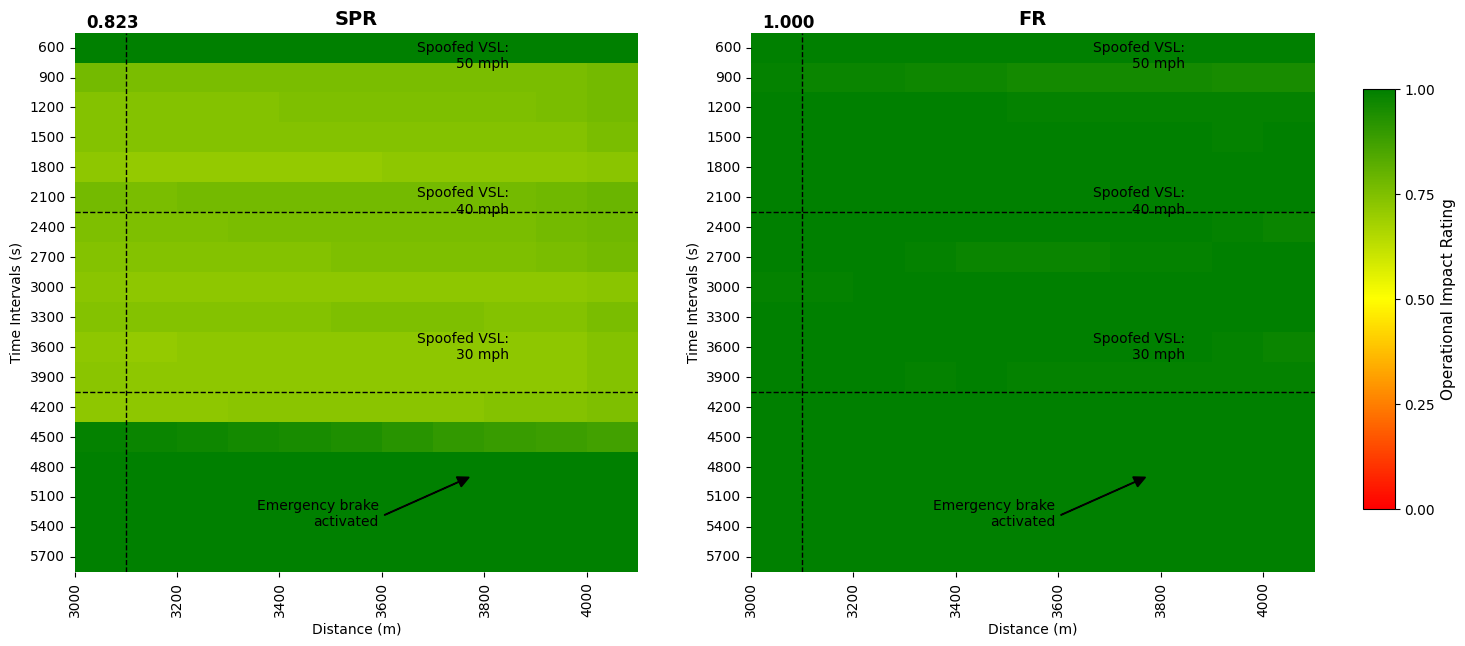

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize, LinearSegmentedColormap

# Load the CSV file with the manually added distance column
file_path = "e1/aggregatedv3.csv"
df = pd.read_csv(file_path)

# Convert `time_bin` and `distance` to integers for proper sorting and filtering
df["interval_begin"] = df["interval_begin"].astype(int)
df["pos"] = df["pos"].astype(int)

# Sort data by `time_bin` (ascending) and `distance` (ascending)
df = df.sort_values(by=["interval_begin", "pos"])

# Define the range for data to include in the heatmap
distance_start = 3000     # Start distance (inclusive)
distance_end   = 4000    # End distance (inclusive)
time_start     = 600     # Start time (inclusive)
time_end       = 6900    # End time (inclusive)

# Adjust time values so the smallest becomes 0
min_time = df["interval_begin"].min()
df["adjusted_time"] = df["interval_begin"] - min_time

# Filter data based on the defined distance and time ranges
filtered_df = df[(df["pos"] >= distance_start) & (df["pos"] <= distance_end)]
filtered_df = filtered_df[(filtered_df["interval_begin"] >= time_start) & (filtered_df["interval_begin"] <= time_end)]

# Create pivot tables using `distance` instead of `detectorID`
spr_matrix = filtered_df.pivot(index="adjusted_time", columns="pos", values="SPR")
fr_matrix  = filtered_df.pivot(index="adjusted_time", columns="pos", values="FR")

# Calculate the mean for SPR and FR within the specified range
spr_mean = spr_matrix.mean().mean()
fr_mean  = fr_matrix.mean().mean()

print("SPR Mean:", spr_mean, "FR Mean:", fr_mean)

def plot_heatmaps(spr_matrix, fr_matrix):
    cmap = LinearSegmentedColormap.from_list("fixed", ["red", "yellow", "green"], N=256)
    norm = Normalize(vmin=0.0, vmax=1.0)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.2})
    cbar_ax = fig.add_axes([0.93, 0.2, 0.02, 0.6])

    # --- SPR Heatmap (left) ---
    sns.heatmap(spr_matrix, cmap=cmap, norm=norm, cbar=False, ax=axes[0])
    axes[0].set_title("SPR", fontsize=14, fontweight="bold")
    axes[0].set_xlabel("Distance (m)")
    axes[0].set_ylabel("Time Intervals (s)")

    # Example: label x‐ticks more sparsely
    # col_positions = np.arange(1, len(spr_matrix.columns), 2)
    # axes[0].set_xticks(col_positions)
    # # axes[0].set_xticks(np.arange(0, len(spr_matrix.columns), 2))
    # axes[0].set_xticklabels(spr_matrix.columns[::2], rotation=90)

    step = 2
    col_positions = np.arange(0, len(spr_matrix.columns), step)
    axes[0].set_xticks(col_positions)
    axes[0].set_xticklabels(spr_matrix.columns[col_positions], rotation=90)

    # --- FR Heatmap (right) ---
    sns.heatmap(fr_matrix, cmap=cmap, norm=norm, cbar=False, ax=axes[1])
    axes[1].set_title("FR", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("Distance (m)")
    axes[1].set_ylabel("Time Intervals (s)")
    # axes[1].set_ylabel("")  # no label needed if you prefer
    # col_positions = np.arange(1, len(spr_matrix.columns), 2)
    # axes[1].set_xticks(col_positions)
    # # axes[1].set_xticks(np.arange(0, len(fr_matrix.columns), 2))
    # axes[1].set_xticklabels(fr_matrix.columns[::2], rotation=90)

    step = 2
    col_positions = np.arange(0, len(spr_matrix.columns), step)
    axes[1].set_xticks(col_positions)
    axes[1].set_xticklabels(spr_matrix.columns[col_positions], rotation=90)

    # --- Add shared colorbar on the right
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)
    cbar.set_label("Operational Impact Rating", fontsize=11)
    cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
    cbar.set_ticklabels(["0.00", "0.25", "0.50", "0.75", "1.00"])

    # --- Add SOI text in top-left corners
    # We need spr_mean and fr_mean from the outer scope, so either pass them in or close over them
    axes[0].text(
        x=0.02, y=1.02, s=f"{spr_mean:.3f}",
        fontsize=12, color="black", fontweight="bold",
        transform=axes[0].transAxes, ha="left", va="center"
    )
    axes[1].text(
        x=0.02, y=1.02, s=f"{fr_mean:.3f}",
        fontsize=12, color="black", fontweight="bold",
        transform=axes[1].transAxes, ha="left", va="center"
    )

    # ------------------------------------------------------------------------
    #  Add lines for distance=3000, 4000; time=2400, 4200, 6000 on both plots
    # ------------------------------------------------------------------------
    # We'll define a small function to draw the lines for each matrix & subplot
    def draw_lines(ax, matrix):
        # If distance/time not in matrix, get_loc(...) would fail, so we check
        distances_to_mark = [3100, 4100]
        times_to_mark     = [2400, 4200, 6000]

        for dist_val in distances_to_mark:
            if dist_val in matrix.columns:
                col_idx = matrix.columns.get_loc(dist_val)
                ax.axvline(x=col_idx, color="k", linestyle="--", lw=1)

        for t_val in times_to_mark:
            if t_val in matrix.index:
                row_idx = matrix.index.get_loc(t_val)
                ax.axhline(y=row_idx, color="k", linestyle="--", lw=1)

    # Draw lines for the SPR subplot
    draw_lines(axes[0], spr_matrix)
    # Draw lines for the FR subplot
    draw_lines(axes[1], fr_matrix)

    # ------------------------------------------------------------------------
    #  Add the same text (and optional arrow) to BOTH subplots
    # ------------------------------------------------------------------------
    for ax in axes:
        # Example text items
        ax.text(
            0.77, 0.93, "Spoofed VSL:\n50 mph",
            transform=ax.transAxes,
            ha="right", va="bottom",
            color="black", fontsize=10
        )
        ax.text(
            0.77, 0.66, "Spoofed VSL:\n40 mph",
            transform=ax.transAxes,
            ha="right", va="bottom",
            color="black", fontsize=10
        )
        ax.text(
            0.77, 0.39, "Spoofed VSL:\n30 mph",
            transform=ax.transAxes,
            ha="right", va="bottom",
            color="black", fontsize=10
        )
        ax.text(
            0.54, 0.08, "Emergency brake\nactivated",
            transform=ax.transAxes,
            ha="right", va="bottom",
            color="black", fontsize=10
        )

        # Example arrow
        ax.arrow(
            0.55, 0.105,           # tail (axes fraction)
            0.7 - 0.55, 0.175 - 0.105,  # head offset
            transform=ax.transAxes,
            color="black",
            linewidth=1,
            head_width=0.02,
            head_length=0.02,
            length_includes_head=True,
            zorder=10
        )

    plt.tight_layout(rect=[0, 0, 0.90, 1])
    plt.savefig("SPRFRlow.png", dpi=300, bbox_inches="tight")
    plt.show()

# Now call the plotting function
plot_heatmaps(spr_matrix, fr_matrix)
